In [8]:
pip install Textblob -q

In [2]:
pip install scikit-learn -q

In [3]:
pip install vaderSentiment -q

In [4]:
pip install pysbd -q

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import pandas as pd
import tensorflow as tf
from keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, pipeline
import pickle






In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_location = '/content/drive/MyDrive/SentimentAnalysis/LLM/khalilNewest.csv'
output_location = '/content/drive/MyDrive/SentimentAnalysis/LLM/'

In [10]:
data = pd.read_csv(data_location)
data = data.iloc[:825,] # This line removes a memory where the valence is zero (invalid)
data

,Memory_text,Song,Singer,Year,Condition,Memory_year,Valence,Subject,Word Count,Unnamed: 9,Unnamed: 10,Average Word Count,28.03878788
0,driving back from walmart with my ex in his mw...,Save Your Tears,Ariana Grande,2021.0,Lyrics,2022.0,1.0,60.0,18.0,NaN,NaN,SD,10.994855
1,heard it on tiktok edits in 2021. Also remembe...,Stay,The Kid LAROI,2022.0,Music,2021.0,1.0,61.0,21.0,NaN,NaN,NaN,NaN
2,An old roommate used to listen to this song so...,Heat Waves,Glass Animals,2022.0,Music,2022.0,1.0,46.0,17.0,NaN,NaN,NaN,NaN
3,I have been through a heartbreak and I have a ...,Without Me,Halsey,2019.0,Name,2022.0,1.0,76.0,34.0,NaN,NaN,NaN,NaN
4,remember this playing all the time over the sp...,Memories,Maroon 5,2020.0,Name,2021.0,1.0,59.0,19.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,When I first got hired as a Personal Trainer w...,Cold Heart,Dua Lipa,2022.0,Song,2023.0,5.0,27.0,32.0,NaN,NaN,NaN,NaN
821,this song reminds me of going on runs in summe...,Stay,The Kid LAROI,2022.0,Song,2023.0,5.0,75.0,40.0,NaN,NaN,NaN,NaN
822,listening to that song in my best friend's kit...,Heat Waves,Glass Animals,2022.0,Song,2021.0,5.0,60.0,13.0,NaN,NaN,NaN,NaN
823,when i hear this song all i can remember is th...,Heat Waves,Glass Animals,2022.0,Song,2021.0,5.0,72.0,28.0,NaN,NaN,NaN,NaN


In [11]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [34]:
import spacy
import pandas as pd
import numpy as np
import json
import time
from collections import Counter
import re

# preprocessing steps (lakshays pipeline)
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
             'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
             'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these',
             'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
             'did', 'doing', 'would', 'should', 'could', 'ought', 'i\'m', 'you\'re', 'he\'s', 'she\'s', 'it\'s', 'we\'re', 'they\'re',
             'i\'ve', 'you\'ve', 'we\'ve', 'they\'ve', 'i\'d', 'you\'d', 'he\'d', 'she\'d', 'we\'d', 'they\'d', 'i\'ll', 'you\'ll',
             'he\'ll', 'she\'ll', 'we\'ll', 'they\'ll', 'let\'s', 'that\'s', 'who\'s', 'what\'s', 'here\'s', 'there\'s', 'when\'s',
             'where\'s', 'why\'s', 'how\'s', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
             'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',
             'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
             'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'will', '\'s']

def lemmatizer(memory, model):
    # convert the memory given to tokenized sentence
    sentence = model(memory)

    # extract lemmatized form of all the tokens in the sentence
    # lemmata = [token.lemma_.lower() for token in sentence]
    lemmata = ['sing' if token.text.lower() == 'singing' else token.lemma_.lower()
               for token in sentence]  # tackling edge case since spacy model is lemmatizing 'singing' to 'singe' instead of 'sing'

    # join the lemmatized tokens to get the final lemmatized sentence
    final_sentence = ' '.join(lemmata)

    return final_sentence


def remove_stopwords(memory, stopwords):

    # Tokenize the memory (split into words)
    words = memory.lower().split()

    # Filter out stopwords
    filtered_words = [word for word in words if word not in stopwords]

    # Reconstruct the cleaned text
    cleaned_memory = ' '.join(filtered_words)

    return cleaned_memory


def find_custom_stopwords(memories_list):

    # combine all memories together to get custom stopwords
    memories = ' '.join(memories_list)

    # tokenize the combined memories
    tokens = memories.split()

    # count the frequency of each token and store it
    token_counts = Counter(tokens)
    frequencies = np.array(list(token_counts.values()))
    # print('frequency: ', sorted(frequencies, reverse=True),
    #       len(frequencies), np.sum(frequencies))
    mean_freq = np.mean(frequencies)  # mean of the frequency of tokens
    std_freq = np.std(frequencies)  # SD of the frequency of tokens

    # threshold of computing the custom stopwords is set to MEAN + 4*SD
    threshold = mean_freq + 4 * std_freq

    custom_stopwords = {word for word, count in token_counts.items()
                        if count > threshold}
    # Output results
    print(f"Token Frequencies (only showing Mean + 1 SD = {np.int32(mean_freq+std_freq)} tokens for now):",
          token_counts.most_common(np.int32(mean_freq+std_freq)))
    # print("Token Frequencies:", token_counts)
    print("Mean Frequency:", mean_freq)
    print("Standard Deviation:", std_freq)
    print('Threshold Frequency (Mean + 4 SDs): ', threshold)
    print("Custom Stopwords (4 SDs above mean):", custom_stopwords)

    return custom_stopwords


def remove_puncuation(memory):

    # Regex pattern to match all punctuation marks
    pattern = r"[^\w\s]"

    # Remove all punctuation marks
    memory_no_punctuation = re.sub(pattern, "", memory)

    return memory_no_punctuation


def preprocessing_pipeline(memories_list, stopwords):

    model = spacy.load(f'en_core_web_lg')

    print('\n\t\t >>>>>> STARTING PREPROCESSING STEPS <<<<<<\n\n')
    start = time.time()

    # 1. lemmatizing works good + lowering also done
    print("Step 1:: Starting lemmatization!\n")
    memories_list = [lemmatizer(memory, model) for memory in memories_list]

    # 2. now check for stopwords and remove the one's from snowball stopwords list
    print("Step 2:: Removing snowball stopwords (without negators and including 's token)!\n")
    memories_list = [remove_stopwords(memory, stopwords)
                     for memory in memories_list]

    # 3. remove all the punctuation marks now
    print("Step 3:: Removing punctuation marks!\n")
    memories_list = [remove_puncuation(memory) for memory in memories_list]

    # 4. now check for custom stopwords based on words occuring >3SDs away
    print("Step 4:: Finding custom stopwords!")
    custom_stopwords = find_custom_stopwords(memories_list)

    # 5. remove the custom stopwords now
    print("\nStep 5:: Removing custom stopwords now!\n")
    memories_list = [remove_stopwords(memory, custom_stopwords)
                     for memory in memories_list]

    print('FINAL:: Total time taken for all the preprocessing: ', time.time()-start)

    return memories_list

np.random.seed(1234)
data["memory_processed"] = preprocessing_pipeline(data["Memory_text"], stopwords)

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



		 >>>>>> STARTING PREPROCESSING STEPS <<<<<<


Step 1:: Starting lemmatization!

Step 2:: Removing snowball stopwords (without negators and including 's token)!

Step 3:: Removing punctuation marks!

Step 4:: Finding custom stopwords!
Token Frequencies (only showing Mean + 1 SD = 35 tokens for now): [('song', 859), ('remember', 297), ('friend', 236), ('listen', 227), ('remind', 227), ('play', 224), ('time', 146), ('school', 134), ('think', 128), ('hear', 126), ('go', 115), ('one', 114), ('not', 102), ('music', 101), ('use', 97), ('summer', 94), ('tiktok', 91), ('come', 91), ('first', 90), ('video', 90), ('sing', 90), ('watch', 89), ('memory', 86), ('radio', 84), ('dance', 84), ('also', 82), ('car', 82), ('like', 81), ('make', 79), ('drive', 78), ('popular', 71), ('lot', 56), ('get', 56), ('just', 54), ('see', 53)]
Mean Frequency: 6.772640911969601
Standard Deviation: 28.736264203256127
Threshold Frequency (Mean + 4 SDs):  121.71769772499411
Custom Stopwords (4 SDs above mean): {'song

In [36]:


def polarity_score(score: float, sentiment_threshold: float):
    if score > sentiment_threshold:
        return 1
    elif score < (-1 * sentiment_threshold):
        return -1
    else:
        return 0

def getPS(a, t):
  out = []
  for i in a:
    out.append(polarity_score(i, t))
  return out

def mySign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

lowerThreshold = 0.2
upperThreshold = 0.6

def fiveClass_score(score, lower, upper):
  if score > upper:
    return 2
  elif score > lower:
    return 1
  elif score >= -1*lower:
    return 0
  elif score >= -1*upper:
    return -1
  elif score >= -1.0:
    return -2


def getFCS(a, l, u):
  out = []
  for i in a:
    out.append(fiveClass_score(i, l, u))
  return out

valenceReal = []
sentimentThreshold = 0.01
analyzer = SentimentIntensityAnalyzer()
vSScores = []
vader5 = []
tb5 = []
sentimentScores = []
real5 = []
words = []
for textIDX in range(data.shape[0]):
  currentText = data['memory_processed'][textIDX]
  words.append(len(currentText.split()))
  currentBlob = TextBlob(currentText)
  sentimentScores.append(currentBlob.sentiment[0])
  vSScores.append(analyzer.polarity_scores(currentText)['compound'])
  tb5.append(fiveClass_score(currentBlob.sentiment[0], lowerThreshold, upperThreshold))
  vader5.append(fiveClass_score(analyzer.polarity_scores(currentText)['compound'], lowerThreshold, upperThreshold))
  valenceReal.append(mySign(data['Valence'][textIDX]-3))
  real5.append(data['Valence'][textIDX]-3)


dataScores = pd.DataFrame({"real3" : valenceReal, "real5" : real5, "tbScores" : sentimentScores, "vScores" : vSScores, "WordCount" : words})


(array([ 67., 152., 196., 128., 157.,  63.,  42.,  11.,   8.,   1.]),
 array([ 2. ,  4.5,  7. ,  9.5, 12. , 14.5, 17. , 19.5, 22. , 24.5, 27. ]),
 <BarContainer object of 10 artists>)

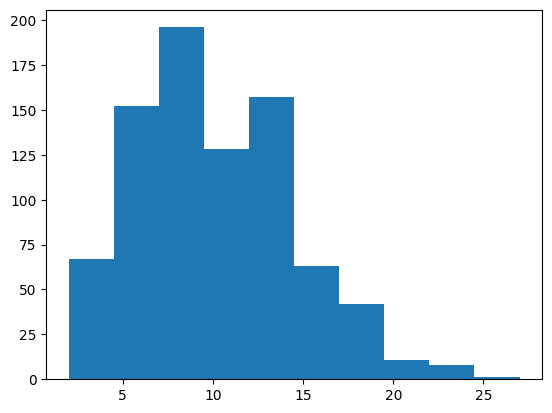

In [ ]:
plt.hist(dataScores["WordCount"])

<ipython-input-37-ee5837d33752>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "Negative", "", "Neutral", "", "Positive", ""])


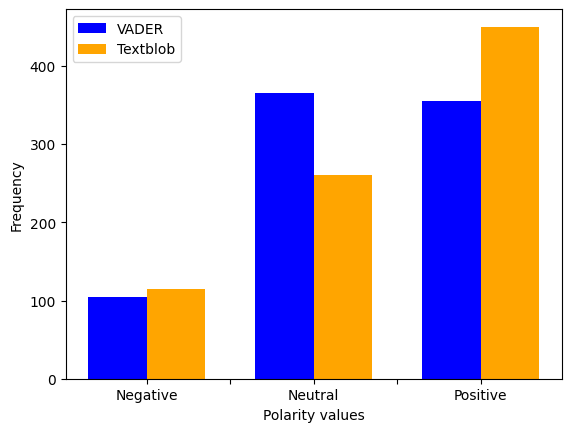

In [37]:
dataScores['TextBlob3'] = getPS(dataScores['tbScores'], sentimentThreshold)
dataScores['VADER3'] = getPS(dataScores['vScores'], sentimentThreshold)

bins = np.arange(-1,3)
hist_textblob, _ = np.histogram(dataScores['TextBlob3'], bins=bins)
hist_vader, _ = np.histogram(dataScores['VADER3'], bins=bins)

width = 0.35

# Creating the figure and axes
fig, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1] - width/2, hist_vader, width=width,
       label='VADER', color='blue')
ax.bar(bins[:-1] + width/2, hist_textblob, width=width,
       label='Textblob', color='orange')

# Adding titles and labels
ax.set_xlabel('Polarity values')
ax.set_xticklabels(["", "Negative", "", "Neutral", "", "Positive", ""])
ax.set_ylabel('Frequency')
ax.legend()

<ipython-input-38-019c3d795b43>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%"])


(-1.5, 1.5)

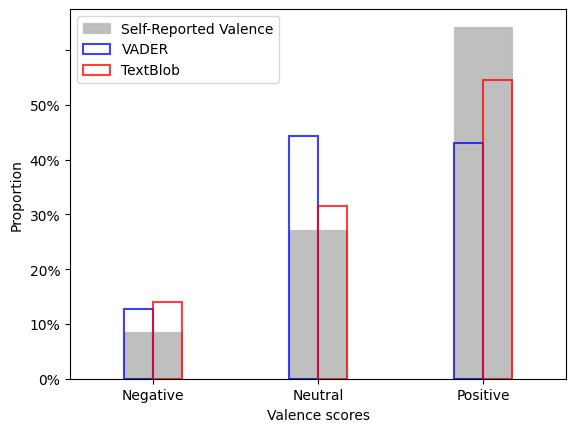

In [38]:
hist_selfvalence, _ = np.histogram(dataScores['real3'], bins=bins)

hist_vader_prob = hist_vader / sum(hist_vader)
hist_textblob_prob = hist_textblob / sum(hist_textblob)
hist_selfvalence_prob = hist_selfvalence / sum(hist_selfvalence)



# Creating the figure and axes
_, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1], hist_selfvalence_prob, width=width,
       label='Self-Reported Valence', alpha=0.5, linewidth=1, color='grey', edgecolor='darkgrey')
ax.bar(bins[:-1] - width/4, hist_vader_prob, width=width/2,
       label='VADER', alpha=0.75, linewidth=1.5, fill=False, edgecolor='blue')
ax.bar(bins[:-1] + width/4, hist_textblob_prob, width=width/2,
       label='TextBlob', alpha=0.75, linewidth=1.5, fill=False, edgecolor='red')

# Adding titles and labels
ax.set_xlabel('Valence scores')
ax.set_ylabel('Proportion')

ax.set_xticks(bins[:-1])
ax.set_xticklabels(["Negative", "Neutral", "Positive"])
ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%"])
ax.legend()
plt.xlim(-1.5, 1.5)

[Text(0, 0, 'Negative'), Text(0, 1, 'Neutral'), Text(0, 2, 'Positive')]

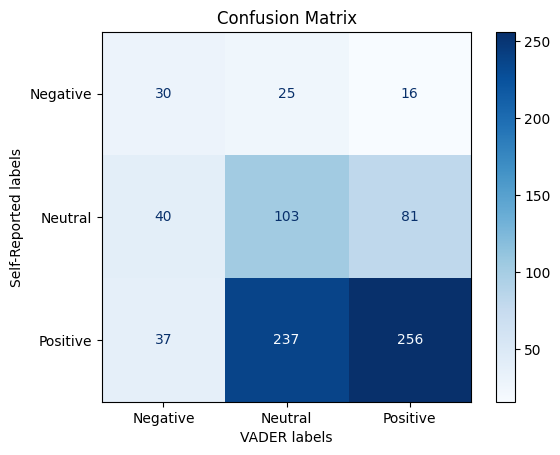

In [29]:
cm = metrics.confusion_matrix(np.array(dataScores['real3']), np.array(dataScores['VADER3']), labels = [-1, 0, 1])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-1, 0, 1])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('VADER labels')
ax.set_xticklabels(['Negative','Neutral',"Positive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Negative','Neutral',"Positive"])

[Text(0, 0, 'Negative'), Text(0, 1, 'Neutral'), Text(0, 2, 'Positive')]

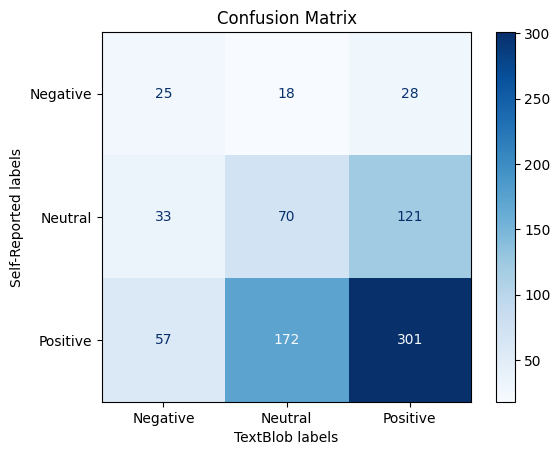

In [30]:
cm = metrics.confusion_matrix(np.array(dataScores['real3']), np.array(dataScores['TextBlob3']), labels = [-1, 0, 1])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-1, 0, 1])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('TextBlob labels')
ax.set_xticklabels(['Negative','Neutral',"Positive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Negative','Neutral',"Positive"])

<ipython-input-39-051fdf4e6437>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["", "Strongly\nNegative", "Negative", "Neutral", "Positive", "Strongly\nPositive",""])


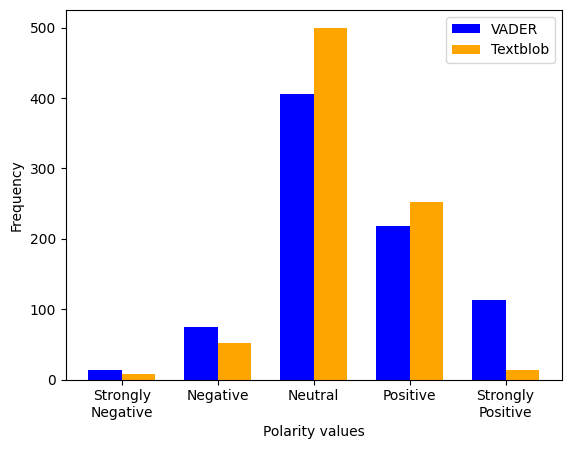

In [39]:
dataScores['TextBlob5'] = getFCS(dataScores['tbScores'], lowerThreshold, upperThreshold)
dataScores['VADER5'] = getFCS(dataScores['vScores'], lowerThreshold, upperThreshold)

bins = np.arange(-2,4)
hist_textblob, _ = np.histogram(dataScores['TextBlob5'], bins=bins)
hist_vader, _ = np.histogram(dataScores['VADER5'], bins=bins)

width = 0.35

# Creating the figure and axes
fig, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1] - width/2, hist_vader, width=width,
       label='VADER', color='blue')
ax.bar(bins[:-1] + width/2, hist_textblob, width=width,
       label='Textblob', color='orange')

# Adding titles and labels
ax.set_xlabel('Polarity values')
ax.set_xticklabels(["", "Strongly\nNegative", "Negative", "Neutral", "Positive", "Strongly\nPositive",""])
ax.set_ylabel('Frequency')
ax.legend()

<ipython-input-40-b665330fe207>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])


(-2.5, 2.5)

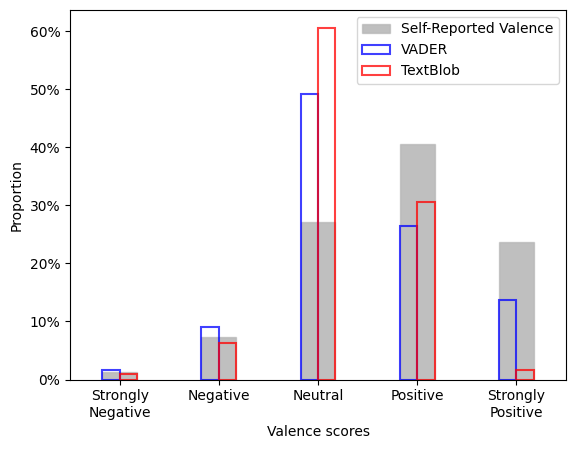

In [40]:
hist_selfvalence, _ = np.histogram(dataScores['real5'], bins=bins)

hist_vader_prob = hist_vader / sum(hist_vader)
hist_textblob_prob = hist_textblob / sum(hist_textblob)
hist_selfvalence_prob = hist_selfvalence / sum(hist_selfvalence)

# Creating the figure and axes
_, ax = plt.subplots()

# Plotting the histograms
ax.bar(bins[:-1], hist_selfvalence_prob, width=width,
       label='Self-Reported Valence', alpha=0.5, linewidth=1, color='grey', edgecolor='darkgrey')
ax.bar(bins[:-1] - width/4, hist_vader_prob, width=width/2,
       label='VADER', alpha=0.75, linewidth=1.5, fill=False, edgecolor='blue')
ax.bar(bins[:-1] + width/4, hist_textblob_prob, width=width/2,
       label='TextBlob', alpha=0.75, linewidth=1.5, fill=False, edgecolor='red')

# Adding titles and labels
ax.set_xlabel('Valence scores')
ax.set_ylabel('Proportion')

ax.set_xticks(bins[:-1])
ax.set_xticklabels(["Strongly\nNegative", "Negative", "Neutral", "Positive", "Strongly\nPositive"])
ax.set_yticklabels(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])
ax.legend()
plt.xlim(-2.5, 2.5)

[Text(0, 0, 'Strongly\nNegative'),
 Text(0, 1, 'Negative'),
 Text(0, 2, 'Neutral'),
 Text(0, 3, 'Positive'),
 Text(0, 4, 'Strongly\nPositive')]

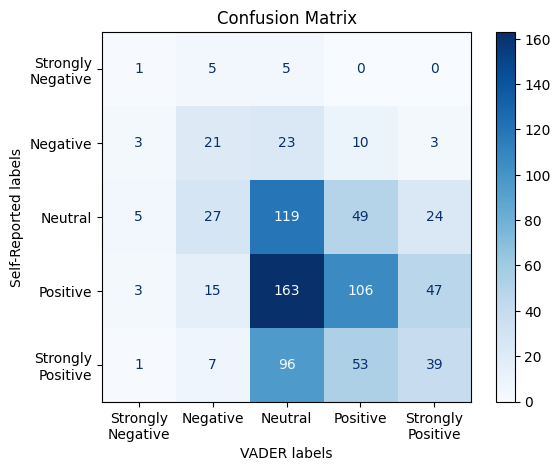

In [41]:
cm = metrics.confusion_matrix(np.array(dataScores['real5']), np.array(dataScores['VADER5']), labels = [-2, -1, 0, 1, 2])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-2, -1, 0, 1, 2])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('VADER labels')
ax.set_xticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])

[Text(0, 0, 'Strongly\nNegative'),
 Text(0, 1, 'Negative'),
 Text(0, 2, 'Neutral'),
 Text(0, 3, 'Positive'),
 Text(0, 4, 'Strongly\nPositive')]

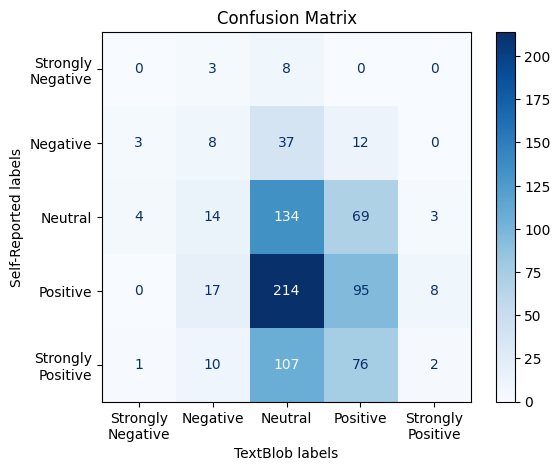

In [42]:
cm = metrics.confusion_matrix(np.array(dataScores['real5']), np.array(dataScores['TextBlob5']), labels = [-2, -1, 0, 1, 2])
display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels= [-2, -1, 0, 1, 2])
fig, ax = plt.subplots()
display.plot(cmap='Blues', ax=ax, values_format='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('TextBlob labels')
ax.set_xticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])
ax.set_ylabel('Self-Reported labels')
ax.set_yticklabels(['Strongly\nNegative','Negative','Neutral',"Positive","Strongly\nPositive"])

In [43]:
print("3Class TextBlob MCC: ", metrics.matthews_corrcoef(dataScores["real3"], dataScores["TextBlob3"]))
print("3Class Vader MCC: ", metrics.matthews_corrcoef(dataScores["real3"], dataScores['VADER3']))
print("5Class TextBlob MCC: ", metrics.matthews_corrcoef(dataScores["real5"], dataScores["TextBlob5"]))
print("5Class Vader MCC: ", metrics.matthews_corrcoef(dataScores["real5"], dataScores["VADER5"]))

3Class TextBlob MCC:  0.05891120894021993
3Class Vader MCC:  0.1180481946527862
5Class TextBlob MCC:  -0.011397081530522784
5Class Vader MCC:  0.0980559736923294


In [ ]:
upperbound = np.percentile(dataScores["WordCount"], 67)
lowerbound = np.percentile(dataScores['WordCount'], 33)

longmems = dataScores.loc[dataScores["WordCount"] > upperbound,:].reset_index()
midmems = dataScores.loc[(dataScores["WordCount"] >= lowerbound) & (dataScores["WordCount"] <= upperbound),:].reset_index()
shortmems = dataScores.loc[dataScores["WordCount"] < lowerbound,:].reset_index()


In [ ]:
print("Long Memories (>12 Words - top 33%)")
print('-----3Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(longmems['VADER3'], longmems['real3']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(longmems['TextBlob3'], longmems['real3']))
print('-----5Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(longmems['VADER5'], longmems['real5']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(longmems['TextBlob5'], longmems['real5']))

Long Memories (>12 Words - top 33%)
-----3Class-----
VADER MCC:  0.20336628577985494
TextBlob MCC:  0.08285940402446351
-----5Class-----
VADER MCC:  0.17170381120303846
TextBlob MCC:  -0.011623960034493265


In [ ]:
print("Middle Length Memories (7-12 Words - middle 34%)")
print('-----3Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(midmems['VADER3'], midmems['real3']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(midmems['TextBlob3'], midmems['real3']))
print('-----5Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(midmems['VADER5'], midmems['real5']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(midmems['TextBlob5'], midmems['real5']))

Middle Length Memories (7-12 Words - middle 34%)
-----3Class-----
VADER MCC:  0.0059456752292227875
TextBlob MCC:  0.00433820433632749
-----5Class-----
VADER MCC:  0.02048982432479719
TextBlob MCC:  -0.03069300662443632


In [ ]:
print("Short Memories (<7 Words - bottom 33%)")
print('-----3Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(shortmems['VADER3'], shortmems['real3']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(shortmems['TextBlob3'], shortmems['real3']))
print('-----5Class-----')
print('VADER MCC: ', metrics.matthews_corrcoef(shortmems['VADER5'], shortmems['real5']))
print('TextBlob MCC: ', metrics.matthews_corrcoef(shortmems['TextBlob5'], shortmems['real5']))

Short Memories (<7 Words - bottom 33%)
-----3Class-----
VADER MCC:  0.22096831047087753
TextBlob MCC:  0.10621287211113642
-----5Class-----
VADER MCC:  0.1475172255994308
TextBlob MCC:  0.035259576563670604


Testing Thresholds

In [ ]:
# Helper functions that we'll use

# Returns a 3 class score
# Is symmetric
def polarity_score(score: float, sentiment_threshold: float):
    if score > sentiment_threshold:
        return 1
    elif score < (-1 * sentiment_threshold):
        return -1
    else:
        return 0

# Wrapper function to apply polarity_score to an array
def getPS(a, t):
  out = []
  for x in a:
    out.append(polarity_score(x, t))
  return out

# Returns a 3 class score, but allows asymmetric thresholds
# n is the negative threshold and p is positive one
def asymmetricPolarity(a, n, p):
  polarities = []
  for x in a:
    if x > p:
      polarities.append(1)
    elif x < n:
      polarities.append(-1)
    else:
      polarities.append(0)
  return polarities

# Returns a 5 class score
# Is symmetric
def fiveClass_score(score, lower, upper):
  if score > upper:
    return 2
  elif score > lower:
    return 1
  elif score > -1*lower:
    return 0
  elif score > -1*upper:
    return -1
  else:
    return -2

# Wrapper function that applies fiveClass_score to an array
def fcScore_list(a, lb, ub):
  out = []
  for x in a:
    out.append(fiveClass_score(x, lb, ub))
  return out

# Essentially polarity score, but with no threshold
def mySign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

# Wrapper function for mySign
def getSigns(a):
  out = []
  for i in a:
    out.append(mySign(i))
  return out

In [ ]:
# 3 Class Threshold Analysis function
def threeClassTA(ds):
  tbScores = ds["tbScores"]
  vScores = ds["vScores"]
  real3 = ds["real3"]

  positiveThresholds = np.arange(0.00, 1, 0.01)
  negativeThresholds = np.arange(0.00, 1, 0.01) * -1

  tbMCC = []
  vMCC = []
  pT = []
  nT = []
  for p in positiveThresholds:
    for n in negativeThresholds:
      tbScored = asymmetricPolarity(tbScores, n, p)
      vScored = asymmetricPolarity(vScores, n, p)

      pT.append(p)
      nT.append(n)

      tbMCC.append(metrics.matthews_corrcoef(real3, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real3, vScored))

  return pd.DataFrame({'PositiveThresholds': pT, 'NegativeThresholds': nT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})



# 5 Class Threhsold Analysis Function
def fiveClassTA(ds):
  tbScores = ds["tbScores"]
  vScores = ds["vScores"]
  real5 = ds["real5"]

  lowerbounds = np.arange(0.00, 1, 0.01)

  tbMCC = []
  vMCC = []
  lbT = []
  ubT = []
  for lb in lowerbounds:
    upperbounds = np.arange(lb+0.01, 1, 0.01)
    for ub in upperbounds:
      tbScored = fcScore_list(tbScores, lb, ub)
      vScored = fcScore_list(vScores, lb, ub)

      lbT.append(lb)
      ubT.append(ub)

      tbMCC.append(metrics.matthews_corrcoef(real5, tbScored))
      vMCC.append(metrics.matthews_corrcoef(real5, vScored))

  return pd.DataFrame({'Lowerbounds': lbT, 'Upperbounds': ubT, 'TextBlobMCC': tbMCC, 'VADERMCC': vMCC})

# Makes the MCC heat plots
# ds3 is the 3classTA ds
# ds5 is the 5classTA ds
def heatPlots(ds3, ds5):
  plt.subplot(2,2,1)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.title("Vader MCC Scores")
  plt.xlabel("Positive Threshold")
  plt.ylabel("Negative Threshold")

  plt.subplot(2,2,2)
  plt.scatter(ds3["PositiveThresholds"], ds3["NegativeThresholds"], c = ds3["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.title("TextBlob MCC Scores")
  plt.xlabel("Positive Threshold")


  plt.subplot(2,2,3)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["VADERMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.xlabel("Lowerbounds")
  plt.ylabel("Upperbounds")

  plt.subplot(2,2,4)
  plt.scatter(ds5["Lowerbounds"], ds5["Upperbounds"], c = ds5["TextBlobMCC"], s = 2, linewidth = 2, cmap = "coolwarm")
  clb = plt.colorbar()
  clb.ax.set_title(' MCC', size = 7)
  plt.xlabel("Lowerbounds")
  plt.subplots_adjust(hspace = .3, wspace = .3)

  plt.show()

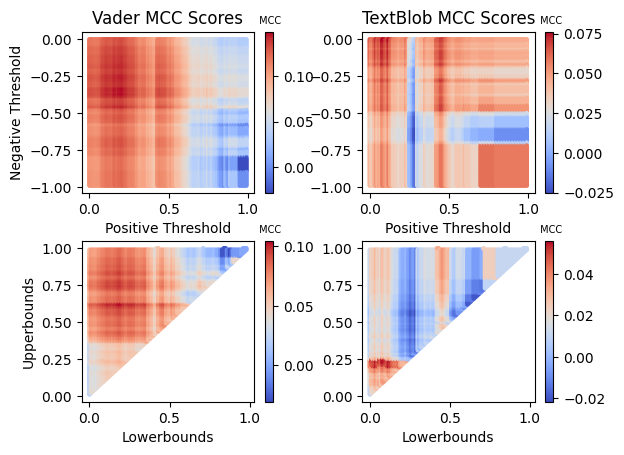

In [ ]:
out3 = threeClassTA(dataScores)
out5 = fiveClassTA(dataScores)

heatPlots(out3, out5)

In [ ]:
print("Best 3-Class Thresholds - VADER: Positive: ", np.round(out3["PositiveThresholds"][out3["VADERMCC"].argmax()], 2), " Negative: ", np.round(out3["NegativeThresholds"][out3["VADERMCC"].argmax()], 2))
print("Best 3-Class Thresholds - TextBlob: Positive: ", np.round(out3["PositiveThresholds"][out3["TextBlobMCC"].argmax()], 2), " Negative: ", np.round(out3["NegativeThresholds"][out3["TextBlobMCC"].argmax()], 2))
print("Best 5-Class Thresholds - Vader: Lowerbound: ", np.round(out5["Lowerbounds"][out5["VADERMCC"].argmax()], 2), " Upperbound: ", np.round(out5["Upperbounds"][out5["VADERMCC"].argmax()], 2))
print("Best 5-Class Thresholds - TextBlob: Lowerbounds: ", np.round(out5["Lowerbounds"][out5["TextBlobMCC"].argmax()], 2), " Upperbound: ", np.round(out5["Upperbounds"][out5["TextBlobMCC"].argmax()], 2))


Best 3-Class Thresholds - VADER: Positive:  0.21  Negative:  -0.38
Best 3-Class Thresholds - TextBlob: Positive:  0.08  Negative:  -0.0
Best 5-Class Thresholds - Vader: Lowerbound:  0.19  Upperbound:  0.62
Best 5-Class Thresholds - TextBlob: Lowerbounds:  0.12  Upperbound:  0.24


In [ ]:
print("MCC of Best 3-Class Thresholds - VADER: ", out3["VADERMCC"][out3["VADERMCC"].argmax()])
print("MCC of Best 3-Class Thresholds - TextBlob: ", out3["TextBlobMCC"][out3["TextBlobMCC"].argmax()])
print("MCC of Best 5-Class Thresholds - VADER: ", out5["VADERMCC"][out5["VADERMCC"].argmax()])
print("MCC of Best 5-Class Thresholds - TextBlob: ", out5["TextBlobMCC"][out5["TextBlobMCC"].argmax()])

MCC of Best 3-Class Thresholds - VADER:  0.14833841750865245
MCC of Best 3-Class Thresholds - TextBlob:  0.07603033688728376
MCC of Best 5-Class Thresholds - VADER:  0.10457405419886076
MCC of Best 5-Class Thresholds - TextBlob:  0.05590783287836516
